# n-dimensional convolution

In [1]:
import bruges
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import welly

## Load logs and make wavelet

In [2]:
well = welly.Well.from_las('../data/R-39.las')

In [3]:
vp = 1e6 / well.data['DT4P']
vs = 1e6 / well.data['DT4S']
rho = well.data['RHOB']

In [4]:
rc = bruges.reflection.reflectivity(vp, vs, rho, theta=np.arange(60))
rc = np.array(rc)  # For some reason it's much slower now if it stays as a welly.Curve

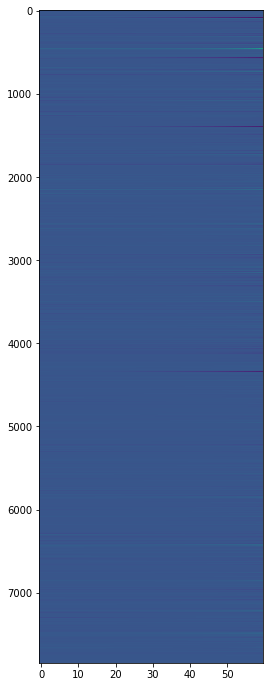

In [9]:
plt.figure(figsize=(4, 12))
plt.imshow(rc.real.T, aspect='auto')

In [91]:
w, t = bruges.filters.ricker(0.128, 0.001, 25, return_t=True)

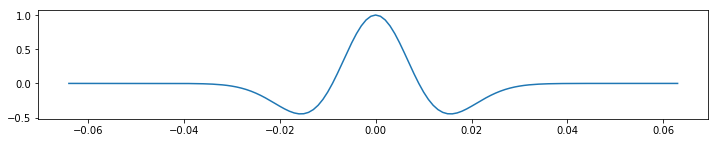

In [92]:
plt.figure(figsize=(12,2))
plt.plot(t, w)
plt.show()

## Problem statement

We want to convolve a 1D wavelet (above) with a 2D reflectivity panel (say, offset on x-axis, depth on y-axis).

In [93]:
w.shape

(128,)

In [94]:
rc.shape

(60, 7842)

The result will be a 2D synthetic seismogram with the same shape as the RC series panel. 

## `np.apply_along_axis()`

I usually use this so let's say it's the reference.

In [196]:
syn_ref = syn = np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'), arr=rc, axis=-1)

In [197]:
syn_ref.shape

(60, 7842)

In [198]:
# np.apply_along_axis()
%timeit np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'), arr=rc, axis=-1)

24.5 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


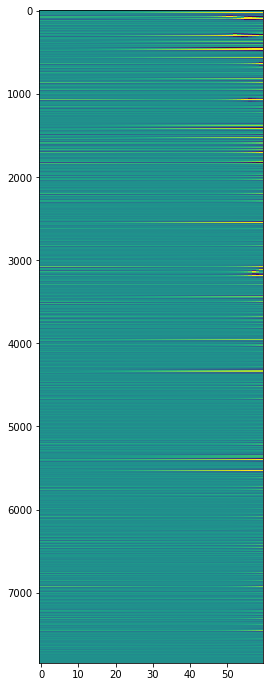

In [199]:
plt.figure(figsize=(4, 12))
plt.imshow(syn.real.T, aspect='auto', vmin=-0.5, vmax=0.5)

In [200]:
syn_ref.shape

(60, 7842)

In [201]:
syn_ref[-1]

array([-0.06703077+0.j, -0.08622652+0.j, -0.10868912+0.j, ...,
        0.00041171+0.j,  0.00034947+0.j,  0.00028974+0.j])

## Convolutional operator

In [101]:
import scipy.signal

In [102]:
from scipy import linalg as spla
def convmtx(h, n):
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return spla.toeplitz(col_1, row_1)[:, h.size//2:1-h.size//2]

In [103]:
# Forward operator and dot product.
G = convmtx(w, rc.shape[1])

In [104]:
syn = G @ rc.T

In [105]:
np.allclose(syn.T, syn_ref, rtol=1e-3)

False

Hm, result is different anyway &mdash; I don't know why.

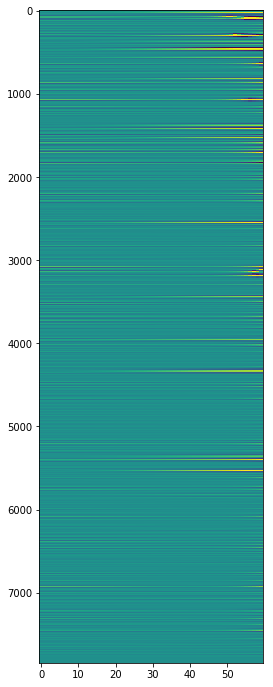

In [106]:
plt.figure(figsize=(4, 12))
plt.imshow(syn.real, aspect='auto', vmin=-0.5, vmax=0.5)

And it's very slow.

In [107]:
%timeit G @ rc.T

531 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## `map()`

In [202]:
syn = np.array(list(map(lambda tr: np.convolve(tr, w, mode='same'), rc)))

In [203]:
np.allclose(syn_ref, syn)

True

In [204]:
%timeit np.array(list(map(lambda tr: np.convolve(tr, w, mode='same'), rc)))

25 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This used to be faster than `np.apply_along_axis()` but now seems to be a tiny bit slower.

## List comprehension

In [205]:
syn = np.array([np.convolve(tr, w, mode='same') for tr in rc])

In [206]:
np.allclose(syn_ref, syn)

True

In [207]:
%timeit np.array([np.convolve(tr, w, mode='same') for tr in rc])

25.6 ms ± 399 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


About the same as `map()`.

## FFT convolution

This requires `scipy` so I don't want it in bruges.

In [114]:
syn = scipy.signal.fftconvolve(rc, np.expand_dims(w, 0), mode='same')

In [115]:
np.allclose(syn_ref, syn)

True

In [116]:
%timeit scipy.signal.fftconvolve(rc, np.expand_dims(w, 0), mode='same')

40.3 ms ± 4.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is the almost same speed as `apply_along_axis`

## Time-domain convolution

In [117]:
syn = scipy.signal.convolve(rc, np.expand_dims(w, 0), mode='same')

In [118]:
np.allclose(syn_ref, syn)

True

In [119]:
%timeit scipy.signal.convolve(rc, np.expand_dims(w, 0), mode='same')

64.2 ms ± 4.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## `scipy.signal.convolve2d()`

In [120]:
syn = scipy.signal.convolve2d(rc, np.expand_dims(w, 0), mode='same')

In [121]:
np.allclose(syn_ref, syn)

True

In [122]:
%timeit scipy.signal.convolve2d(rc, np.expand_dims(w, 0), mode='same')

242 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
np.expand_dims(w, 0).shape

(1, 128)

## Wavelet banks

What about convolving a 2D wavelet bank with a 2D reflectivity?

In [124]:
bank = bruges.filters.ricker(0.128, 0.001, np.arange(5, 50))

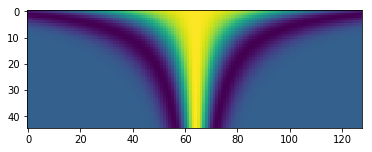

In [125]:
plt.imshow(bank)

### Using `apply_along_axis`

In [126]:
# syn_ref = syn = np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'), arr=rc, axis=-1)

syn_ = np.array([np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'),
                                     axis=0,
                                     arr=r)
                 for r in rc for w in bank ]) 

In [127]:
# syn_ref = syn = np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'), arr=rc, axis=-1)

%timeit np.array([np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'), axis=0, arr=r) for r in rc for w in bank ]) 

1.7 s ± 219 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [128]:
syn_.shape

(2700, 7842)

In [129]:
syn_ = syn_.reshape(rc.shape[0], bank.shape[0], -1)

In [130]:
syn_.shape

(60, 45, 7842)

In [131]:
np.allclose(syn_ref, syn_[:, 20])  # Freq is in axis 1

True

### Using `map`

In [132]:
# np.array(list(map(lambda tr: np.convolve(tr, w, mode='same'), rc)))

syn_ = np.array([list(map(lambda tr: np.convolve(tr, w, mode='same'), rc)) for w in bank])

In [133]:
# np.array(list(map(lambda tr: np.convolve(tr, w, mode='same'), rc)))

%timeit np.array([list(map(lambda tr: np.convolve(tr, w, mode='same'), rc)) for w in bank])

1.83 s ± 203 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [134]:
syn_.shape

# freq, offset, time

(45, 60, 7842)

In [135]:
syn_[5].shape

(60, 7842)

In [136]:
np.allclose(syn_ref, syn_[20])

True

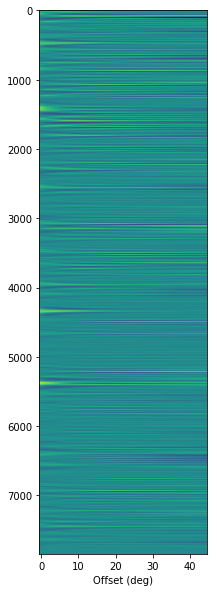

In [137]:
plt.figure(figsize=(3, 10))
plt.imshow(syn_.real[:, 20].T, aspect='auto')
plt.xlabel('Offset (deg)')
plt.show()

Let's look at a timeslice through this thing:

In [138]:
from ipywidgets import interact

@interact()
def make_plot(t=2000):
    extent = [0, 60, 5, 50]
    ma = np.percentile(syn_.real, 99)

    plt.imshow(syn_.real[:, :, t],
               origin='lower', extent=extent,
               vmin=-ma, vmax=ma)

    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Angle (deg)')
    plt.grid(c='k', alpha=0.1)
    plt.colorbar(shrink=0.9)
    return

interactive(children=(IntSlider(value=2000, description='t', max=6000, min=-2000), Output()), _dom_classes=('w…

## Turn into functions

In [208]:

def apply_along_axis(func_1d, arr, *args, **kwargs):
    """
    Apply 1D function across 2D slice as efficiently as possible.
    
    Arr must be 2D
    
    np.apply_along_axis() seems to be faster than it used to be... test.
    """
    mapobj = map(lambda tr: func_1d(tr, *args, **kwargs), arr)
    return np.array(list(mapobj))


def convolve(reflectivity, wavelet, verbose=True):
    """
    Convolve reflectivity with wavelet as efficiently as possible. 
    """
    # Compute the target shape of the final synthetic.
    outshape = wavelet.shape[:-1] + reflectivity.shape
    
    # Force wavelet and reflectivity to both be 2D.
    bank = np.atleast_2d(wavelet)   
    reflectivity_2d = reflectivity.reshape((-1, reflectivity.shape[-1]))
    
    # Compute synthetic, which will always be 3D.
    syn = np.array([apply_along_axis(np.convolve, reflectivity_2d, w, mode='same') for w in bank])
    
    # Show the shapes of the data we're handling.
    if verbose:
        print(reflectivity.shape, ' * ', wavelet.shape, ' -> ', outshape)

    return syn.reshape(outshape)


def convolve_np(reflectivity, wavelet, verbose=True):
    """
    Convolve reflectivity with wavelet using np.apply_along_axis under the hood.
    
    For now, this seems to be slightly slower than the approach using map, above.
    I don't know why, because they were very similar in the tests above.
    """
    # Compute the target shape of the final synthetic.
    outshape = wavelet.shape[:-1] + reflectivity.shape
    
    # Force wavelet and reflectivity to both be 2D.
    bank = np.atleast_2d(wavelet)   
    reflectivity_2d = reflectivity.reshape((-1, reflectivity.shape[-1]))
    
    # Compute synthetic, which will always be 3D.
    syn = np.array([np.apply_along_axis(lambda tr: np.convolve(tr, w, mode='same'),
                                        arr=reflectivity_2d,
                                        axis=-1)
                    for w in bank])
    
    # Show the shapes of the data we're handling.
    if verbose:
        print(reflectivity.shape, ' * ', wavelet.shape, ' -> ', outshape)

    return syn.reshape(outshape)



### 1D RC, 1D wavelet -> 1D synthetic

In [186]:
syn = convolve(rc[0], w)

(7842,)  *  (128,)  ->  (7842,)


In [141]:
syn.shape

(7842,)

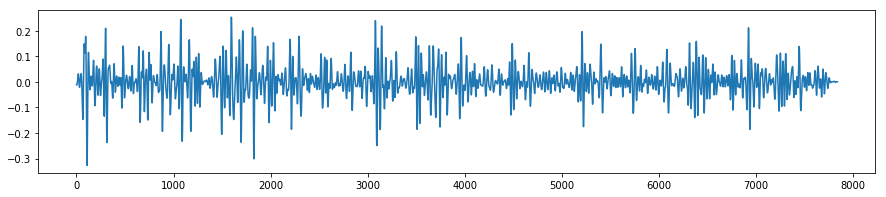

In [142]:
plt.figure(figsize=(15, 3))
plt.plot(syn.real)

In [143]:
syn

array([-0.01148584+0.j, -0.01207649+0.j, -0.01243219+0.j, ...,
        0.00039356+0.j,  0.00032891+0.j,  0.00026912+0.j])

### 2D RC, 1D wavelet -> 2D synthetic

In [144]:
syn = convolve(rc, w)

(60, 7842)  *  (128,)  ->  (60, 7842)


In [145]:
syn.shape

(60, 7842)

In [146]:
np.allclose(syn_ref, syn)

True

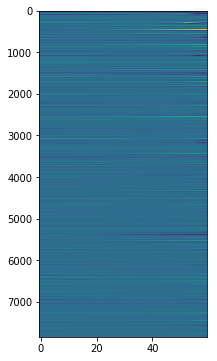

In [147]:
plt.figure(figsize=(3, 6))
plt.imshow(syn.real.T, aspect='auto')

### 2D RC, 2D wavelet -> 3D synthetic

In [148]:
bank.shape, rc.shape

((45, 128), (60, 7842))

In [149]:
syn_ = convolve(rc, bank)

(60, 7842)  *  (45, 128)  ->  (45, 60, 7842)


In [150]:
syn_.shape

# freq, offset, time

(45, 60, 7842)

In [151]:
np.allclose(syn_ref, syn_[20])

True

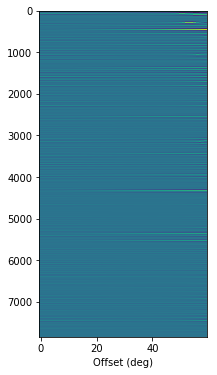

In [152]:
plt.figure(figsize=(3, 6))
plt.imshow(syn_.real[10].T, aspect='auto')
plt.xlabel('Offset (deg)')
plt.show()

### 1D RC, 2D wavelet -> 2D synthetic

In [153]:
rc.shape, bank.shape

((60, 7842), (45, 128))

In [154]:
syn_ = convolve(rc[0], bank)

(7842,)  *  (45, 128)  ->  (45, 7842)


In [155]:
syn_.shape

(45, 7842)

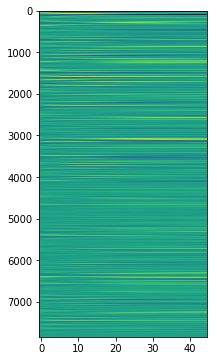

In [156]:
plt.figure(figsize=(3, 6))
plt.imshow(syn_.real.T, aspect='auto')

### 3D RC series, 1D wavelet -> 3D synthetic

Let's make a 3D reflectivity volume. Maybe this new dimension represents _x_ position (e.g. along a seismic line).

In [157]:
rc_ = np.repeat(rc[None, ...], 10, axis=0)

rc_.shape

(10, 60, 7842)

In [158]:
syn__ = convolve(rc_, w)

syn__.shape

(10, 60, 7842)  *  (128,)  ->  (10, 60, 7842)


(10, 60, 7842)

### 3D RC, 2D wavelet -> 4D synthetic

We'll use only compare 1000 time samples otherwise this might get quite big. I'll include more in the window though because we'll get an edge effect from the convolution.

In [159]:
syn_4d = convolve(np.array(rc_)[..., :1200], bank)

(10, 60, 1200)  *  (45, 128)  ->  (45, 10, 60, 1200)


Shape is:

`freq, position, offset, time`

In [160]:
syn_4d.shape

(45, 10, 60, 1200)

In [161]:
np.allclose(syn_ref[..., :1000], syn_4d[20, 5, :, :1000])

True

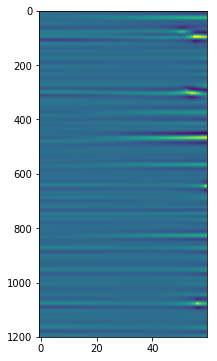

In [162]:
plt.figure(figsize=(3, 6))
plt.imshow(syn_4d[20, 5, :, :].real.T, aspect='auto')

### 4D RC, 2D wavelet -> 5D synthetic

If it works with this, I'm calling it a day.

In [188]:
rc_4D = np.repeat(rc_[None, :5, :30, :600], 4, axis=0)

rc_4D.shape

(4, 5, 30, 600)

In [189]:
syn_5d = convolve(rc_4D, bank[:21])

(4, 5, 30, 600)  *  (21, 128)  ->  (21, 4, 5, 30, 600)


In [190]:
%timeit syn_5d = convolve(rc_4D, bank[:21], verbose=False)

485 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [191]:
syn_5d = convolve(rc_4D, bank[:21], verbose=False)
syn_5d.shape

(21, 4, 5, 30, 600)

In [192]:
%timeit syn_5d_ = convolve_np(rc_4D, bank[:21], verbose=False)

657 ms ± 82.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [193]:
syn_5d_ = convolve_np(rc_4D, bank[:21], verbose=False)
syn_5d_.shape

(21, 4, 5, 30, 600)

In [194]:
np.allclose(syn_5d.real, syn_5d_.real, rtol=0.01)

True

Awesome!